step 1. 필요한 라이브러리 설치

In [ ]:
!pip install fastapi langserve langchain_core uvicorn sse_starlette python-multipart pyngrok streamlit langchain-openai langchain-community httpx==0.23.0 unstructured "unstructured[pdf]" faiss-cpu
!npm install localtunnel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 21.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of unstructured-client to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of unstructured-client to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹
added 22 packages in 3s
⠹
⠹3 packages are looking for funding
⠹  run `npm fund` for details
⠹

step 2. main.py 파일 생성

In [ ]:
file_content='''import os
import streamlit as st
from langchain.embeddings import CacheBackedEmbeddings
from langchain.storage import LocalFileStore
from langchain_openai import OpenAIEmbeddings
from langchain_community.embeddings.huggingface import HuggingFaceEmbeddings
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_core.messages import ChatMessage
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders.unstructured import UnstructuredFileLoader
from langchain_community.vectorstores.faiss import FAISS
from langserve import RemoteRunnable
from langchain_openai import ChatOpenAI
from langchain_core.callbacks.streaming_stdout import StreamingStdOutCallbackHandler

# ⭐️ Embedding 값 설정
# USE_BGE_EMBEDDING = True 로 설정시 HuggingFace BAAI/bge-m3 임베딩 사용 (2.7GB 다운로드 시간 걸릴 수 있습니다)
# USE_BGE_EMBEDDING = False 로 설정시 OpenAIEmbeddings 사용 (OPENAI_API_KEY 입력 필요. 과금)
USE_BGE_EMBEDDING = True

if not USE_BGE_EMBEDDING:
    # OPENAI API KEY 입력
    # Embedding 을 무료 한글 임베딩으로 대체하면 필요 없음!
    os.environ["OPENAI_API_KEY"] = "OPENAI API KEY 입력"

# ⭐️ LangServe 모델 설정(EndPoint)
# 1) REMOTE 접속: 본인의 REMOTE LANGSERVE 주소 입력
# (예시)
# LANGSERVE_ENDPOINT = "https://poodle-deep-marmot.ngrok-free.app/llm/"
LANGSERVE_ENDPOINT = "https://radically-top-jaguar.ngrok-free.app/llm/"

# 2) LocalHost 접속: 끝에 붙는 N4XyA 는 각자 다르니
# http://localhost:8000/llm/playground 에서 python SDK 에서 확인!
# LANGSERVE_ENDPOINT = "http://localhost:8000/llm/c/N4XyA"

# 필수 디렉토리 생성 @Mineru
if not os.path.exists(".cache"):
    os.mkdir(".cache")
if not os.path.exists(".cache/embeddings"):
    os.mkdir(".cache/embeddings")
if not os.path.exists(".cache/files"):
    os.mkdir(".cache/files")

# 프롬프트를 자유롭게 수정해 보세요!
RAG_PROMPT_TEMPLATE = """당신은 질문에 친절하게 답변하는 AI 입니다. 검색된 다음 문맥을 사용하여 질문에 답하세요. 답을 모른다면 모른다고 답변하세요.
Question: {question}
Context: {context}
Answer:"""

st.set_page_config(page_title="OLLAMA Local 모델 테스트", page_icon="💬")
st.title("OLLAMA Local 모델 테스트")

if "messages" not in st.session_state:
    st.session_state["messages"] = [
        ChatMessage(role="assistant", content="무엇을 도와드릴까요?")
    ]

def print_history():
    for msg in st.session_state.messages:
        st.chat_message(msg.role).write(msg.content)

def add_history(role, content):
    st.session_state.messages.append(ChatMessage(role=role, content=content))

def format_docs(docs):
    for doc in docs:
        print("doc:", doc)
        print("page_content:", getattr(doc, "page_content", "No page_content"))
    return "\n\n".join(doc.page_content for doc in docs if hasattr(doc, "page_content"))

@st.cache_resource(show_spinner="Embedding file...")
def embed_file(file):
    file_content = file.read()
    file_path = f"./.cache/files/{file.name}"
    with open(file_path, "wb") as f:
        f.write(file_content)

    cache_dir = LocalFileStore(f"./.cache/embeddings/{file.name}")

    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=500,
        chunk_overlap=50,
        separators=["\n\n", "\n", "(?<=\. )", " ", ""],
        length_function=len,
    )
    loader = UnstructuredFileLoader(file_path)
    docs = loader.load_and_split(text_splitter=text_splitter)

    if USE_BGE_EMBEDDING:
        # BGE Embedding: @Mineru
        model_name = "BAAI/bge-m3"
        # GPU Device 설정:
        # - NVidia GPU: "cuda"
        # - Mac M1, M2, M3: "mps"
        # - CPU: "cpu"
        model_kwargs = {
            # "device": "cuda"
            # "device": "mps"
            "device": "cpu"
        }
        encode_kwargs = {"normalize_embeddings": True}
        embeddings = HuggingFaceEmbeddings(
            model_name=model_name,
            model_kwargs=model_kwargs,
            encode_kwargs=encode_kwargs,
        )
    else:
        embeddings = OpenAIEmbeddings()
    cached_embeddings = CacheBackedEmbeddings.from_bytes_store(embeddings, cache_dir)
    vectorstore = FAISS.from_documents(docs, embedding=cached_embeddings)
    retriever = vectorstore.as_retriever()
    return retriever

with st.sidebar:
    file = st.file_uploader(
        "파일 업로드",
        type=["pdf", "txt", "docx"],
    )

if file:
    retriever = embed_file(file)

print_history()

if user_input := st.chat_input():
    add_history("user", user_input)
    st.chat_message("user").write(user_input)
    with st.chat_message("assistant"):
        # ngrok remote 주소 설정
        ollama = RemoteRunnable(LANGSERVE_ENDPOINT)
        chat_container = st.empty()
        if file is not None:
            prompt = ChatPromptTemplate.from_template(RAG_PROMPT_TEMPLATE)

            # 체인을 생성합니다.
            rag_chain = (
                {
                    "context": retriever | format_docs,
                    "question": RunnablePassthrough(),
                }
                | prompt
                | ollama
                | StrOutputParser()
            )
            # 문서에 대한 질의를 입력하고, 답변을 출력합니다.
            answer = rag_chain.stream(user_input)  # 문서에 대한 질의
            chunks = []
            for chunk in answer:
                chunks.append(chunk)
                chat_container.markdown("".join(chunks))
            add_history("ai", "".join(chunks))
        else:
            prompt = ChatPromptTemplate.from_template(
                "다음의 질문에 간결하게 답변해 주세요:\n{input}"
            )

            # 체인을 생성합니다.
            chain = prompt | ollama | StrOutputParser()

            answer = chain.stream(user_input)  # 문서에 대한 질의
            chunks = []
            for chunk in answer:
                chunks.append(chunk)
                chat_container.markdown("".join(chunks))
            add_history("ai", "".join(chunks))'''

# 파일 생성 및 내용 쓰기
with open("/content/main.py", "w") as file:
    file.write(file_content)

step 3. 백그라운드로 main.py 실행

In [ ]:
!nohup streamlit run main.py &
!nohup npx localtunnel --port 8501 &

nohup: appending output to 'nohup.out'
nohup: appending output to 'nohup.out'


- 일반 질문
  - 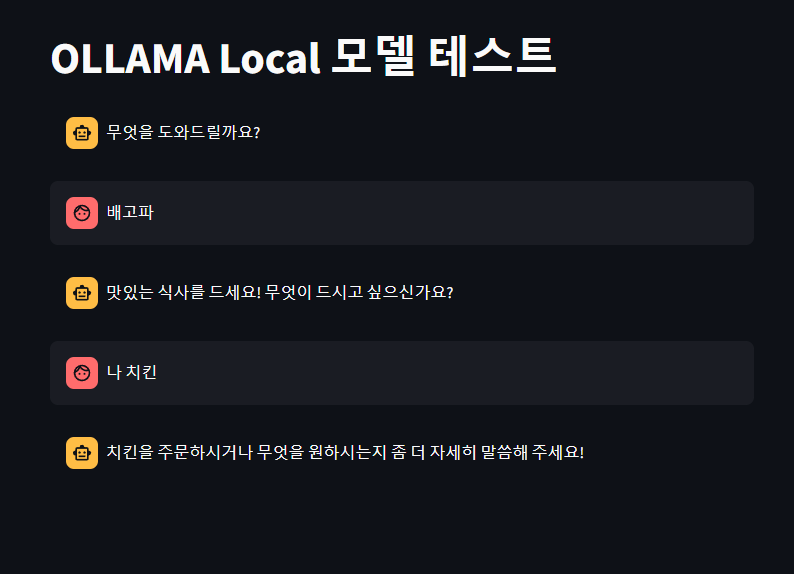


- Attention Is All You Need paper를 업로드후 질문
  - 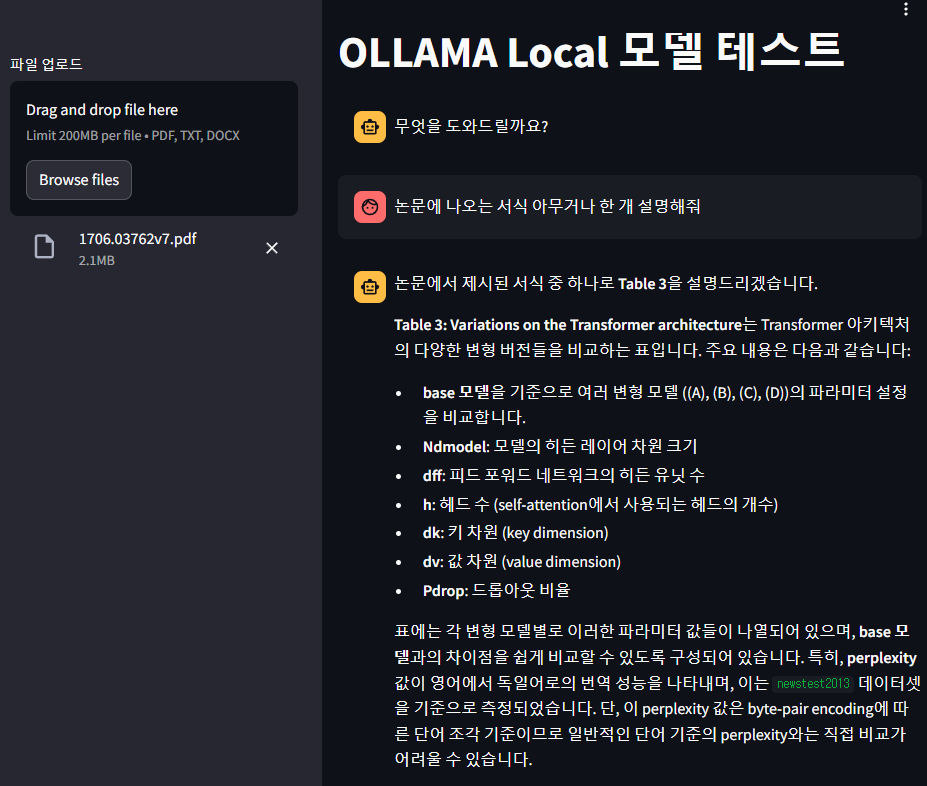